## OOR benchmark - design comparison

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import numpy as np
import scanpy as sc

import oor_benchmark
from oor_benchmark.api import check_dataset
from oor_benchmark.datasets.simulation import simulate_query_reference
from oor_benchmark.methods import scArches_milo
from oor_benchmark.methods.scArches_milo import run_milo
from oor_benchmark.api import check_dataset, check_method
from oor_benchmark.metrics.utils import make_OOR_per_group
from oor_benchmark.metrics.FDR_TPR_FPR import FDR_TPR_FPR
from oor_benchmark.metrics.auprc import auprc
import pandas as pd

import milopy
import matplotlib.pyplot as plt
import seaborn as sns

def clean_pop_name(string):
    return(''.join(e if e.isalnum() else '_' for e in string))


In [53]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [54]:
%load_ext rpy2.ipython

In [55]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [10]:
def harmonize_milo_output(acr_adata):
    # Harmonize output
    sample_adata = acr_adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < 0.1) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = acr_adata.obsm["nhoods"].T
    acr_adata.uns["sample_adata"] = sample_adata.copy()

In [4]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
sim_dirs = [outdir + d for d in os.listdir(outdir)]

In [27]:
sim_dir = sim_dirs[2]

acr_adata = milopy.utils.read_milo_adata(sim_dir + '/acr_design.h5ad')
cr_adata = milopy.utils.read_milo_adata(sim_dir + '/cr_design.h5ad')

In [28]:
harmonize_milo_output(acr_adata)
harmonize_milo_output(cr_adata)
assert check_method(acr_adata)
assert check_method(cr_adata)

make_OOR_per_group(acr_adata)
make_OOR_per_group(cr_adata)

In [69]:
FDR_TPR_FPR(cr_adata)['TP'][0] + FDR_TPR_FPR(cr_adata)['FP'][0] == cr_adata.uns['sample_adata'].var['OOR_signif'].sum()

False

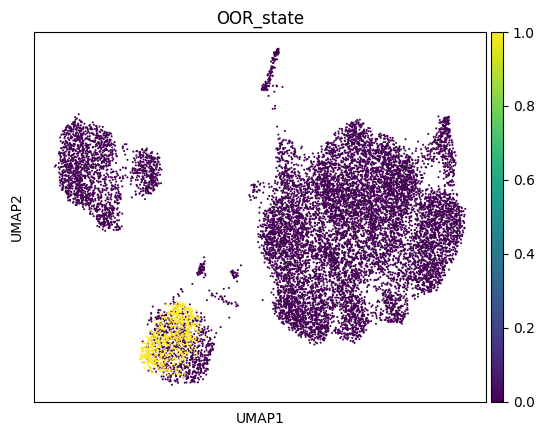

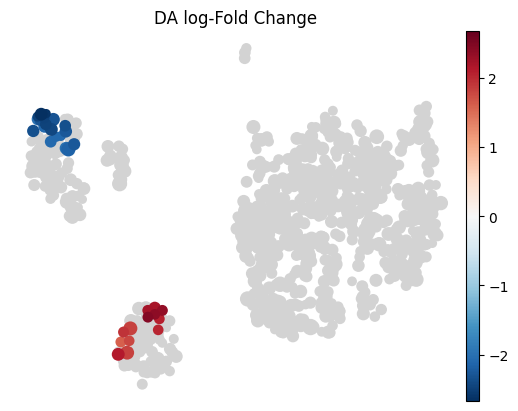

In [16]:
sc.tl.umap(acr_adata)
sc.pl.umap(acr_adata, color=['OOR_state'])
milopy.utils.build_nhood_graph(acr_adata)
milopy.plot.plot_nhood_graph(acr_adata, min_size=1)

In [56]:
out_df = acr_adata.uns['sample_adata'].var[["OOR_signif", "OOR_state_group", 'frac_OOR_cells', "OOR_score"]]
out_df

,OOR_signif,OOR_state_group,frac_OOR_cells,OOR_score
0,0,0,0.000000,0.319781
1,0,0,0.000000,0.353308
2,0,0,0.000000,-0.185165
3,0,0,0.000000,-0.046621
4,0,0,0.000000,-0.732536
...,...,...,...,...
937,0,1,0.535211,1.605441
938,0,0,0.000000,0.536113
939,0,0,0.000000,0.458545
940,0,0,0.000000,-1.004101


In [58]:
%%R -i out_df
head(out_df)

  OOR_signif OOR_state_group frac_OOR_cells  OOR_score
0          0               0              0  0.3197808
1          0               0              0  0.3533084
2          0               0              0 -0.1851652
3          0               0              0 -0.0466207
4          0               0              0 -0.7325362
5          0               0              0  0.1225677


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


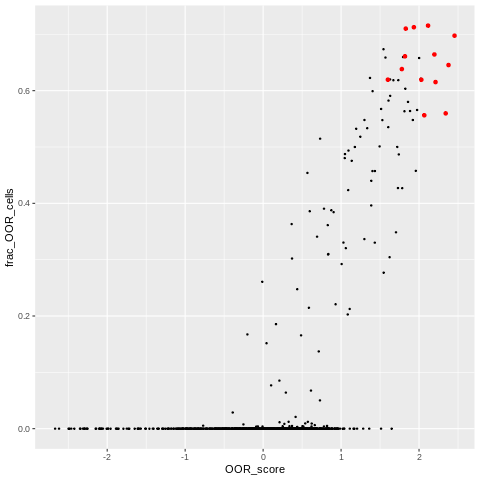

In [62]:
%%R
out_df %>%
ggplot(aes(OOR_score, frac_OOR_cells)) +
geom_point(size=0.5) +
geom_point(data = . %>% filter(OOR_signif == 1), color='red')

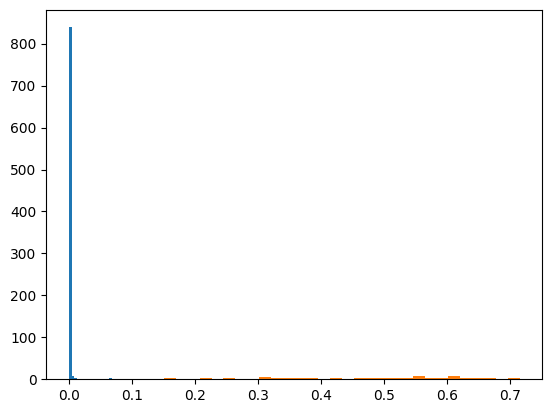

In [50]:
plt.hist(acr_adata.uns['sample_adata'].var['frac_OOR_cells'][acr_adata.uns['sample_adata'].var['OOR_state_group'] == 0], bins=30);
plt.hist(acr_adata.uns['sample_adata'].var['frac_OOR_cells'][acr_adata.uns['sample_adata'].var['OOR_state_group'] == 1], bins=30);

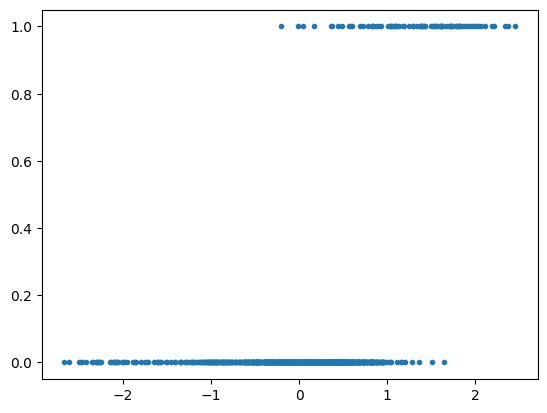

In [46]:
plt.plot(
    acr_adata.uns['sample_adata'].var['OOR_score'], 
    acr_adata.uns['sample_adata'].var['OOR_state_group'], '.')

In [35]:
acr_adata.obs[['donor_id', 'dataset_group']].drop_duplicates().value_counts('dataset_group')

dataset_group
query    16
ctrl     13
dtype: int64

KeyError: 'TP'